In [1]:
% matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import sys
import random
from glob import glob

from multiprocessing import Pool
import numpy as np
import pandas as pd

from tqdm import tqdm
import scipy.misc
from skimage.morphology import label
import skimage

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set some parameters
IMG_CHANNELS = 3
DATA = {
    'TRAIN': '../data/train/',
    'TEST': '../data/test/'
}

train_paths = glob(os.path.join(DATA['TRAIN'], '*'))
test_paths = glob(os.path.join(DATA['TEST'], '*'))

seed = 42
BATCH_SIZE = 16
SIDE = 256
STEP = SIDE // 4

np.random.seed = seed

SPLIT = .9

In [4]:
def load(path, test_mode=False):
    im = scipy.misc.imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
    
    if im.std(-1).sum() > 10:
        im = np.abs(im.astype(np.float).mean(-1) - 255.)
    else:
        im = im.astype(np.float).mean(-1)
    
    if test_mode:
        return im
    
    return np.dstack([
        im,
        np.load(os.path.join(path, 'mask_ibn.npy')),
    ])

In [5]:
def preprocess_val(patch):
    return np.dstack([
        scipy.ndimage.zoom(patch[..., :-1].mean(-1), (SIDE / patch.shape[0], SIDE / patch.shape[1])),
        scipy.ndimage.zoom(patch[..., -1], (SIDE / patch.shape[0], SIDE / patch.shape[1]), order=0)
    ])

In [6]:
def preprocess_test(patch):
    return scipy.ndimage.zoom(patch, (SIDE / patch.shape[0], SIDE / patch.shape[1]))


def generator_test(paths, batch_size=BATCH_SIZE, train_mode=False):
    while True:
        if train_mode:
            np.random.shuffle(paths)
            
        for i in range(len(paths) // batch_size + 1):
            batch = paths[i * batch_size: (i + 1) * batch_size]
#             with Pool(4) as pool:
#                 processed = pool.map(load, batch)
            processed = np.zeros((batch_size, SIDE, SIDE))
            for j, path in enumerate(batch):
                im = load(path, test_mode=True)
                processed[j] = preprocess_test(im)

            yield np.expand_dims(processed, -1) / 255.

In [7]:
def scale_img_canals(an_img):
    for i in range(IMG_CHANNELS):
        canal = an_img[:,:,i]
        canal = canal - canal.min()
        canalmax = canal.max()
        if canalmax > 0:
            canal = (canal * 255 / canalmax).astype(int)
        an_img[:,:,i] = canal
    return an_img

In [8]:
def preprocess(patch):
    scale = np.random.uniform(.5, 1.5, size=2)
    
    if np.random.randint(2):
        patch = np.flip(patch, 0)
    if np.random.randint(2):
        patch = np.flip(patch, 1)
    if np.random.randint(2):
        patch = np.rot90(patch, k=np.random.randint(3) + 1)
    
    if not np.random.randint(3):
        patch = np.concatenate([np.flip(patch, 0), patch, np.flip(patch, 0)])
    if not np.random.randint(3):
        patch = np.concatenate([np.flip(patch, 1), patch, np.flip(patch, 1)], 1)
    
    
    if np.random.randint(4):
        rotate = np.random.uniform(-40, 40)
        patch = np.dstack([
            scipy.ndimage.rotate(patch[..., 0], rotate),
            scipy.ndimage.rotate(patch[..., -1:], rotate, order=0)
        ])
#         patch = skimage.transform.rotate(patch, rotate, mode='constant', preserve_range=True)
    
    window = np.clip(SIDE * scale, 0, min(patch.shape[:-1]))
    if np.count_nonzero(patch[..., -1]):
        coords = np.array(np.where(patch[..., -1]))
        cmin, cmax = coords.min(1) - window, coords.max(1)
        point = np.array([
            np.random.randint(cmin[0], cmax[0]),
            np.random.randint(cmin[1], cmax[1])
        ])
    else:
        point = np.array([
            np.random.randint(0, patch.shape[0] - window[0] + 1),
            np.random.randint(0, patch.shape[1] - window[1] + 1)
        ]) 
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window).astype(np.int)

    patch = patch[
        point[0]: point[0] + int(window[0]), 
        point[1]: point[1] + int(window[1])
    ]
    
    return np.dstack([
        scipy.ndimage.zoom(patch[..., 0],  (SIDE / patch.shape[0], SIDE / patch.shape[1])),
        scipy.ndimage.zoom(patch[..., -1],  (SIDE / patch.shape[0], SIDE / patch.shape[1]), order=0)
    ])

In [9]:
def generator(paths, preprocess, batch_size=BATCH_SIZE, train_mode=False):
    while True:
        if train_mode:
            np.random.shuffle(paths)
            
        for i in range(len(paths) // batch_size + 1):
            batch = paths[i * batch_size: (i + 1) * batch_size]
#             with Pool(4) as pool:
#                 processed = pool.map(load, batch)
            processed = np.zeros((batch_size, SIDE, SIDE, 2))
            for j, path in enumerate(batch):
                im = load(path)
                processed[j] = preprocess(im)

            yield np.expand_dims(processed[..., 0], -1) / 255., np.expand_dims(processed[..., -1], -1)

In [10]:
train_gen = generator(train_paths, preprocess, batch_size=BATCH_SIZE, train_mode=True)
a = next(train_gen)

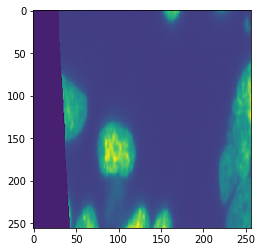

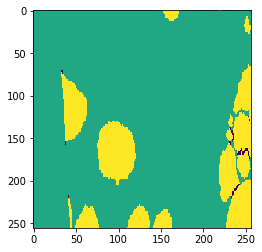

In [11]:
i = 2
plt.imshow(a[0][i,...,0])
plt.show()
plt.imshow(a[1][i,...,0])

In [122]:
# std_paths = list()
# for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):
#     img = imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
#     mask = list()
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         mask.append(imread(path + '/masks/' + mask_file))
#     std_paths.append((path, img.std(-1).sum(), len(mask)))
#     mask = np.array(mask).max(0)
#     np.save(path + '/mask', mask)


# std_paths = list()
# for n, path in tqdm(enumerate(test_paths), total=len(test_paths)):
#     img = scipy.misc.imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
#     std_paths.append((path, img.std(-1).sum()))


# for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):
#     mask = list()
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         im = scipy.misc.imread(path + '/masks/' + mask_file)
#         im = scipy.ndimage.distance_transform_edt(im)
#         im[im == 0] = 1e+7
#         mask.append(im)
#     mask = np.array(mask).min(0)
#     mask[mask == 1e+7] = 0
#     mask[scipy.ndimage.binary_dilation((mask == 1), iterations=2) & np.logical_not(mask >= 1.1)] = -1
#     mask[mask > 0] = 1
#     np.save(path + '/mask_edt_bn', mask)


training = list()
for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):
    mask = list()
    annotations = {
        'boxes': list(),
        'filename': os.path.join(path, 'images', os.path.basename(path) + '.png'),
    }
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        im = scipy.misc.imread(os.path.join(path, 'masks', mask_file))
        yy, xx = np.where(im)
        annotations['boxes'].append({
            'class': 'nuclei', 
            'x1': xx.min(), 
            'x2': xx.max(), 
            'y1': yy.min(), 
            'y2': yy.max()
        })
        
    annotations['shape'] = scipy.misc.imread(annotations['filename']).shape
    training.append(annotations)

# sizes_test = dict()
# print('Getting and resizing test images ... ')
# sys.stdout.flush()
# for n, path in tqdm(enumerate(test_paths), total=len(test_paths)):
#     img = scipy.misc.imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
#     sizes_test[path] = ([img.shape[0], img.shape[1]])

100%|██████████| 670/670 [01:00<00:00, 11.00it/s]


In [123]:
sys.path.append('../models/keras-rcnn/')
import keras_rcnn.datasets.malaria_phenotypes
import keras_rcnn.preprocessing
import keras_rcnn.models
import keras

In [132]:
classes = {
    "nuclei": 1
}

# np.random.shuffle(training)
generator = keras_rcnn.preprocessing.ObjectDetectionGenerator()
generator = generator.flow(training, classes, batch_size=1, shuffle=False)

In [133]:
target_image.max()

1.0

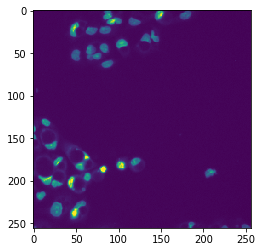

In [134]:
plt.imshow(target_image.astype(np.float).mean(-1))

In [135]:
path

'../data/train/c620631271a56407d6d69fa1a69451ca99c50dcc30e29db04cf6fb7cacbde8cb'

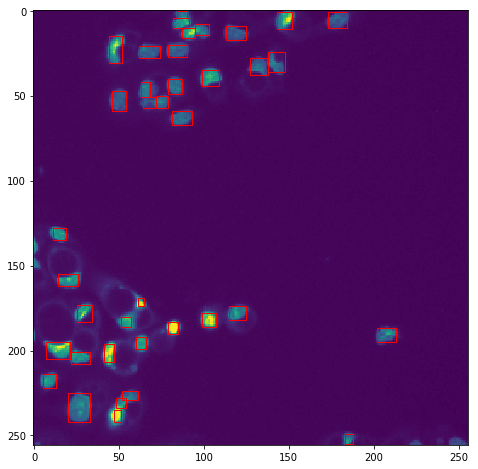

In [136]:
(target_bounding_boxes, target_image, target_scores, _), _ = generator.next()

target_bounding_boxes = np.squeeze(target_bounding_boxes)

target_image = np.squeeze(target_image)

target_scores = np.argmax(target_scores, -1)
target_scores = np.squeeze(target_scores)

_, axis = matplotlib.pyplot.subplots(1, figsize=(12, 8))

axis.imshow(target_image.astype(np.float).mean(-1))

for target_index, target_score in enumerate(target_scores):
    if target_score > 0:
        xy = [
            target_bounding_boxes[target_index][0],
            target_bounding_boxes[target_index][1]
        ]

        w = target_bounding_boxes[target_index][2] - target_bounding_boxes[target_index][0]
        h = target_bounding_boxes[target_index][3] - target_bounding_boxes[target_index][1]

        rectangle = matplotlib.patches.Rectangle(xy, w, h, edgecolor="r", facecolor="none")

        axis.add_patch(rectangle)

matplotlib.pyplot.show()